# Desarrollo de modelos

### Método del codo

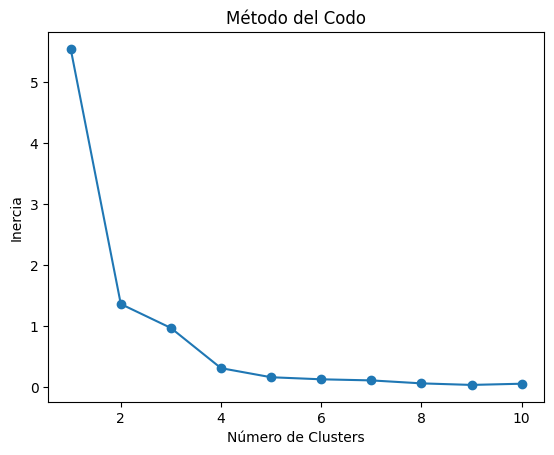

In [6]:
import os
import pandas as pd
from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import TimeSeriesKMeans
import numpy as np
import matplotlib.pyplot as plt

# Carpeta que contiene los archivos .parquet
folder = 'data'

# Fechas de inicio y fin para filtrar las filas
start_date_str = '2021-09-13'
end_date_str = '2022-09-13'

# Convierte los string a objetos datetime
startDate = pd.to_datetime(start_date_str)
endDate = pd.to_datetime(end_date_str)

# Obtiene la lista de archivos .parquet en la carpeta
files = [file for file in os.listdir(folder)[:15] if file.endswith('.parquet')]

# Lista para almacenar las series de tiempo ema100
field = 'ema200'
series = []

# Itera sobre cada archivo .parquet
for fileName in files:
    # Ruta completa al archivo .parquet
    filePath = os.path.join(folder, fileName)

    # Lee el archivo .parquet en un DataFrame de Pandas
    df = pd.read_parquet(filePath)

    # Filtra las filas dentro del rango de fechas
    df['date'] = pd.to_datetime(df['date'])  # Asegurarse de que el campo 'date' sea de tipo datetime
    df = df[(df['date'] >= startDate) & (df['date'] <= endDate)]

    # Verifica si la serie de tiempo contiene solo NaN o tiene longitud cero
    if not df[field].isnull().all() and len(df[field]) > 0:
        series.append(df[field].values)

# Convierte la lista de series de tiempo ema a un formato compatible con tslearn
X = to_time_series_dataset(series)
X = TimeSeriesScalerMeanVariance().fit_transform(X)

maxClusters = 10  # Número máximo de clusters a probar
iterations = 1  # Número de iteraciones

# Inicializa lista para almacenar los resultados
results = []

# Calcula la inercia para diferentes números de clusters y múltiples iteraciones
for nClusters in range(1, maxClusters + 1):
    inertia_values = []
    for iteration in range(1, iterations + 1):
        kmeans = TimeSeriesKMeans(n_clusters=nClusters, metric='dtw', verbose=False)
        kmeans.fit(X)
        inertia = kmeans.inertia_
        inertia_values.append(inertia)
        results.append({'nClusters': nClusters, 'iteration': iteration, 'score': inertia})
    
    # Calcula la media de las inercias para el número actual de clusters
    mean_inertia = np.mean(inertia_values)
    results.append({'nClusters': nClusters, 'iteration': 'mean', 'score': mean_inertia})

# Guarda los resultados en un archivo CSV
results_df = pd.DataFrame(results)
csv_filename = f'metodo_codo_dtw_{maxClusters}_{iterations}_{field}.csv'
results_df.to_csv(csv_filename, index=False)

# Visualización del método del codo
mean_inertias = results_df[results_df['iteration'] == 'mean']['score'].values
plt.plot(range(1, maxClusters + 1), mean_inertias, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.title('Método del Codo')
plt.show()


### Coeficiente de Silhouette

Calculando coeficiente de Silhouette: 100%|██████████| 9/9 [00:20<00:00,  2.24s/it]


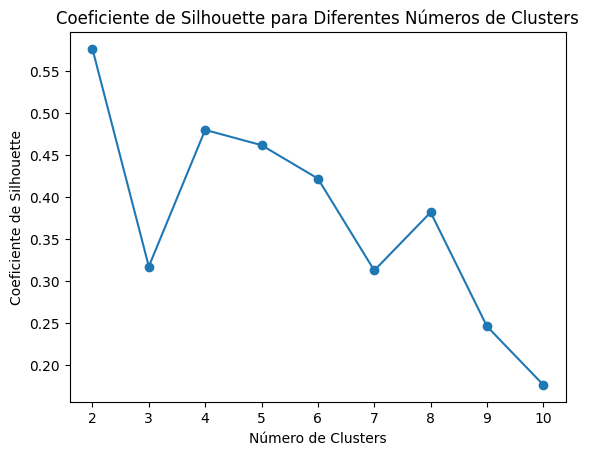

In [3]:
import os
import pandas as pd
from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import TimeSeriesKMeans
from tslearn.metrics import cdist_dtw
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Carpeta que contiene los archivos .parquet
folder = 'data'

# Fechas de inicio y fin para filtrar las filas
start_date_str = '2021-09-13'
end_date_str = '2022-09-13'

# Convierte las cadenas de fecha a objetos de fecha
startDate = pd.to_datetime(start_date_str)
endDate = pd.to_datetime(end_date_str)

# Obtiene la lista de archivos .parquet en la carpeta
files = [file for file in os.listdir(folder) if file.endswith('.parquet')]

# Lista para almacenar las series de tiempo ema100
field = 'ema200'
series = []

# Itera sobre cada archivo .parquet
for fileName in tqdm(files, desc="Procesando archivos .parquet"):
    # Ruta completa al archivo .parquet
    filePath = os.path.join(folder, fileName)

    # Lee el archivo .parquet en un DataFrame de Pandas
    df = pd.read_parquet(filePath)

    # Filtra las filas dentro del rango de fechas
    df['date'] = pd.to_datetime(df['date'])  # Asegurarse de que el campo 'date' sea de tipo datetime
    df = df[(df['date'] >= startDate) & (df['date'] <= endDate)]

    # Verifica si la serie temporal contiene solo NaN o tiene longitud cero
    if not df[field].isnull().all() and len(df[field]) > 0:
        series.append(df[field].values)

# Convierte la lista de series de tiempo ema a un formato compatible con tslearn
X = to_time_series_dataset(series)
X = TimeSeriesScalerMeanVariance().fit_transform(X)

# Define parámetros
minClusters = 2  # Número máximo de clusters a probar
maxClusters = 10  # Número máximo de clusters a probar
iterations = 1  # Número de iteraciones

# Inicializa lista para almacenar los resultados
results = []

# Calcula el coeficiente de silhouette para diferentes números de clusters y múltiples iteraciones
total_iterations = (maxClusters - minClusters + 1) * iterations
progress_bar = tqdm(total=total_iterations, desc="Calculando coeficiente de Silhouette")

for nClusters in range(minClusters, maxClusters + 1):  # El coeficiente de silhouette no está definido para nClusters=1
    silhouette_values = []
    for iteration in range(1, iterations + 1):
        kmeans = TimeSeriesKMeans(n_clusters=nClusters, metric='dtw', verbose=False)
        labels = kmeans.fit_predict(X)
        
        # Calcula la matriz de distancia DTW
        D = cdist_dtw(X)
        
        # Calcula el coeficiente de silhouette usando la matriz de distancia DTW
        silhouette_avg = silhouette_score(D, labels, metric='euclidean')
        silhouette_avg = round(silhouette_avg, 5)  # Redondear a 5 decimales
        silhouette_values.append(silhouette_avg)
        results.append({'nClusters': nClusters, 'iteration': iteration, 'score': silhouette_avg})
        
        # Actualiza la barra de progreso
        progress_bar.update(1)
    
    # Calcula la media de los coeficientes de silhouette para el número actual de clusters
    mean_silhouette = np.mean(silhouette_values)
    mean_silhouette = round(mean_silhouette, 5)  # Redondear a 5 decimales
    results.append({'nClusters': nClusters, 'iteration': 'mean', 'score': mean_silhouette})

progress_bar.close()

# Guarda los resultados en un archivo CSV
results_df = pd.DataFrame(results)
csv_filename = f'coeficiente_silhouette_dtw_{maxClusters}_{iterations}_{field}.csv'
results_df.to_csv(csv_filename, index=False)

# Visualización del coeficiente de silhouette
mean_silhouettes = results_df[results_df['iteration'] == 'mean']['score'].values
plt.plot(range(minClusters, maxClusters + 1), mean_silhouettes, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Coeficiente de Silhouette')
plt.title('Coeficiente de Silhouette para diferentes número de Clústeres')
plt.show()


### Calcular volúmenes totales de criptomonedas y asignar un color

In [3]:
import os
import pandas as pd

# Carpeta que contiene los archivos .parquet
data_folder = 'data'

# Lista para almacenar los nombres de las criptomonedas y sus volúmenes totales
crypto_volumes = []

# Lee los archivos .parquet de la carpeta data
file_list = os.listdir(data_folder)
for file_name in file_list:
    if file_name.endswith('.parquet'):
        # Obtiene el nombre de la criptomoneda sin la parte "-USDT.parquet"
        crypto_name = file_name.replace('-USDT.parquet', '')
        
        # Ruta completa del archivo
        file_path = os.path.join(data_folder, file_name)
        
        # Lee el archivo parquet y sumar el volumen total
        df = pd.read_parquet(file_path)
        total_volume = df['volume_usdt'].sum()
        
        # Agrega la criptomoneda y su volumen total a la lista
        crypto_volumes.append({'Cryptocurrency': crypto_name, 'Total_Volume': total_volume})

# Crea un DataFrame a partir de la lista de diccionarios
crypto_df = pd.DataFrame(crypto_volumes)

# Ordena las criptomonedas por volumen total de menor a mayor
crypto_df = crypto_df.sort_values(by='Total_Volume')

# Agrega una columna que empiece en valor 1 para la de menor volumen
crypto_df['Rank_Volume'] = range(1, len(crypto_df) + 1)

# Escala de grises: el valor más alto de Rank_Volume será negro (#000000) y el más bajo será blanco (#EBEBEB)
max_rank = crypto_df['Rank_Volume'].max()
crypto_df['Color'] = crypto_df['Rank_Volume'].apply(lambda x: '#{0:02x}{0:02x}{0:02x}'.format(int((255 - (x - 1) * 255 / max_rank)), int((255 - (x - 1) * 255 / max_rank)), int((255 - (x - 1) * 255 / max_rank))))

# Guarda el DataFrame como un archivo CSV
crypto_df.to_csv('crypto_volumes.csv', index=False)


### Modificar campo fecha y agregar color a los CSV resultantes de los clústeres

In [4]:
import os
import pandas as pd
from datetime import datetime, timedelta

# Directorio de resultados y archivo de volúmenes
results_dir = 'results'
volumes_file = 'crypto_volumes.csv'

# Lee el archivo de volúmenes
volumes_df = pd.read_csv(volumes_file)
volumes_dict = volumes_df.set_index('Cryptocurrency')['Color'].to_dict()

# Función para convierte date de 0 a fecha real
def convert_date(days):
    start_date = datetime(2021, 9, 13)
    return start_date + timedelta(days=days)

# Procesa todos los archivos CSV en el directorio de resultados
for root, dirs, files in os.walk(results_dir):
    for file in files:
        if file.endswith('.csv'):
            file_path = os.path.join(root, file)
            df = pd.read_csv(file_path)
            
            # Convierte el campo date
            df['date'] = df['date'].apply(convert_date)
            
            # Añade el campo color
            df['color'] = df['cryptocurrency'].apply(
                lambda x: volumes_dict.get(x, '#FF0000') if x != 'Cluster Mean' else '#FF0000'
            )
            
            # Guarda el archivo modificado
            df.to_csv(file_path, index=False)

print("Procesamiento completado.")


Procesamiento completado.


### Definir índice de Dunn

In [1]:
def cluster_distance(cluster1, cluster2):
    # Calcula la distancia entre dos clusters utilizando la distancia mínima entre pares de puntos
    min_distance = float('inf')
    for i in range(len(cluster1)):
        for j in range(len(cluster2)):
            distance = np.linalg.norm(cluster1[i] - cluster2[j])
            if distance < min_distance:
                min_distance = distance
    return min_distance

def intra_cluster_dispersion(cluster):
    # Calcula la dispersión intra-cluster como la media de las distancias entre pares de puntos en el cluster
    total_distance = 0
    num_points = len(cluster)
    for i in range(num_points):
        for j in range(i+1, num_points):
            total_distance += np.linalg.norm(cluster[i] - cluster[j])
    if num_points <= 1:
        return 0
    else:
        return total_distance / (num_points * (num_points - 1) / 2)

def dunn_index(clusters):
    # Calcula el índice de Dunn para un conjunto de clusters
    min_inter_cluster_distance = float('inf')
    max_intra_cluster_dispersion = 0
    num_clusters = len(clusters)
    
    # Calcula la distancia mínima entre clusters
    for i in range(num_clusters):
        for j in range(i+1, num_clusters):
            distance = cluster_distance(clusters[i], clusters[j])
            if distance < min_inter_cluster_distance:
                min_inter_cluster_distance = distance
    
    # Calcula la máxima dispersión intra-cluster
    for i in range(num_clusters):
        dispersion = intra_cluster_dispersion(clusters[i])
        if dispersion > max_intra_cluster_dispersion:
            max_intra_cluster_dispersion = dispersion
    
    # El índice de Dunn es la relación entre la distancia mínima entre clusters y la máxima dispersión intra-cluster
    if max_intra_cluster_dispersion == 0:
        return float('inf')
    else:
        return min_inter_cluster_distance / max_intra_cluster_dispersion


# Clustering Tslearn TimeSeriesKMeans

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.utils import to_time_series_dataset
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from time import time
from tqdm import tqdm

# 1. Lee los archivos .parquet de la carpeta data
data_folder = 'data'  # Carpeta que contiene los archivos .parquet
file_list = os.listdir(data_folder)  # Toma solo los primeros 9 archivos
clusteringMetric = 'dtw'
field = 'price'
nIterations = 5  # Número de iteraciones

# Crea la carpeta 'metrics' si no existe
os.makedirs('metrics', exist_ok=True)

# Archivo CSV para guardar los resultados
csv_file = f'metrics/tslearn-TimeSeriesKMeans-{clusteringMetric}-{field}-{nIterations}.csv'

# 2. Lee los datos de los archivos .parquet y almacenarlos en un diccionario
crypto_data = {}
crypto_dates = {}
for file_name in file_list:
    if file_name.endswith('.parquet'):
        crypto_name = file_name.split('-')[0]  # Nombre de la criptomoneda sin la parte final "-USDT.parquet"
        file_path = os.path.join(data_folder, file_name)
        df = pd.read_parquet(file_path)
        price_data = df[field].values  # Utiliza solo la columna 'ema200'
        date_data = df.index  # Suponiendo que el índice contiene las fechas
        if not np.isnan(price_data).all() and len(price_data) > 0:
            crypto_data[crypto_name] = price_data
            crypto_dates[crypto_name] = date_data

# 3. Preprocesamiento de las series de tiempo
X = [crypto_data[key] for key in crypto_data]  # Lista de series de tiempo
X = to_time_series_dataset(X)  # Convierte a un formato compatible con tslearn
X = TimeSeriesScalerMeanVariance().fit_transform(X)  # Escala las series de tiempo

# Columnas del CSV
columns = ['clusters', 'iteration', 'Silhouette', 'Dunn', 'Davies-Bouldin', 'Calinski-Harabasz', 'time']

# Crea el DataFrame para los resultados
results_df = pd.DataFrame(columns=columns)

total_iterations = 6 * nIterations
progress_bar = tqdm(total=total_iterations, desc=f"Realizando clustering con {nIterations} iteraciones")

# Ejecuta el clustering para diferentes números de clústeres
for n_clusters in range(3, 9):
    silhouette_scores = []
    dunn_indices = []
    davies_bouldin_indices = []
    calinski_harabasz_indices = []
    times = []

    for iteration in range(1, nIterations+1):
        
        start_time = time()  # Registra el tiempo de inicio
        
        # 4. Clustering de series de tiempo
        kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric=clusteringMetric, verbose=False)
        labels = kmeans.fit_predict(X)
        centroids = kmeans.cluster_centers_
        
        end_time = time()  # Registra el tiempo de finalización
        iteration_time = round(end_time - start_time, 5)  # Calcula el tiempo de la iteración
        
        # Actualiza la barra de progreso
        progress_bar.update(1)

        # CALCULA COEFICIENTE DE SILHOUETTE
        X_2d = X.reshape(X.shape[0], -1)  # Convierte a 2D para que sea compatible con silhouette_score
        silhouette_avg = round(silhouette_score(X_2d, labels, metric='euclidean'), 5)

        # CALCULA ÍNDICE DE DUNN
        # Obtiene las series de tiempo de cada cluster
        clusters = []
        for i in range(n_clusters):
            cluster_indices = np.where(labels == i)[0]
            cluster_series = [crypto_data[list(crypto_data.keys())[idx]] for idx in cluster_indices]
            clusters.append(cluster_series)

        dunn = round(dunn_index(clusters), 5)

        # CALCULA ÍNDICE DE DAVIES-BOULDIN
        davies_bouldin = round(davies_bouldin_score(X_2d, labels), 5)

        # CALCULA ÍNDICE DE CALINSKI-HARABASZ
        calinski_harabasz = round(calinski_harabasz_score(X_2d, labels), 5)

        # Agrega los resultados al DataFrame
        new_row = {
            'clusters': n_clusters,
            'iteration': iteration,
            'Silhouette': silhouette_avg,
            'Dunn': dunn,
            'Davies-Bouldin': davies_bouldin,
            'Calinski-Harabasz': calinski_harabasz,
            'time': iteration_time
        }
        results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)

        # Agrega los valores a las listas para el cálculo de la media
        silhouette_scores.append(silhouette_avg)
        dunn_indices.append(dunn)
        davies_bouldin_indices.append(davies_bouldin)
        calinski_harabasz_indices.append(calinski_harabasz)
        times.append(iteration_time)

    # Calcula la media de los índices y agrega una fila al DataFrame
    avg_row = {
        'clusters': n_clusters,
        'iteration': 'Media',
        'Silhouette': round(np.mean(silhouette_scores),5),
        'Dunn': round(np.mean(dunn_indices),5),
        'Davies-Bouldin': round(np.mean(davies_bouldin_indices),5),
        'Calinski-Harabasz': round(np.mean(calinski_harabasz_indices),5),
        'time': round(np.mean(times), 5)
    }
    results_df = pd.concat([results_df, pd.DataFrame([avg_row])], ignore_index=True)
    
    std_row = {
        'clusters': n_clusters,
        'iteration': 'Std',
        'Silhouette': round(np.std(silhouette_scores),5),
        'Dunn': round(np.std(dunn_indices),5),
        'Davies-Bouldin': round(np.std(davies_bouldin_indices),5),
        'Calinski-Harabasz': round(np.std(calinski_harabasz_indices),5),
        'time': round(np.std(times), 5)
    }
    results_df = pd.concat([results_df, pd.DataFrame([std_row])], ignore_index=True)
    
    # Crea la carpeta 'results' si no existe
    os.makedirs('results', exist_ok=True)

    # 5. Muestra las gráficas de los clusters con las series de tiempo
    for i in range(n_clusters):
        cluster_indices = np.where(labels == i)[0]
        cluster_cryptos = []
        cluster_series = []
        cluster_dates = []
        cluster_df = pd.DataFrame()

        for idx in cluster_indices:
            crypto_name = list(crypto_data.keys())[idx]
            if crypto_name in crypto_data:  # Verifica si la criptomoneda está presente en los datos
                cluster_cryptos.append(crypto_name)
                cluster_series.append(crypto_data[crypto_name])
                cluster_dates.append(crypto_dates[crypto_name])

                temp_df = pd.DataFrame({
                    'date': crypto_dates[crypto_name],
                    'cryptocurrency': crypto_name,
                    'price': np.round(crypto_data[crypto_name], 5)
                })
                cluster_df = pd.concat([cluster_df, temp_df])

        # Ajusta todas las series de tiempo a la misma longitud
        min_length = min(len(series) for series in cluster_series)
        cluster_series = [series[:min_length] for series in cluster_series]

        # Calcula la media del clúster
        cluster_mean = np.mean(cluster_series, axis=0)
        cluster_mean = np.round(cluster_mean, 5)  # Redondea la media a 4 decimales

        # Añade la media del clúster al DataFrame
        mean_df = pd.DataFrame({
            'date': range(min_length),
            'cryptocurrency': 'Media',
            'price': cluster_mean
        })
        cluster_df = pd.concat([cluster_df, mean_df])

        # Guarda el DataFrame del clúster en un archivo CSV
        directorio = f'results/tslearn-TimeSeriesKMeans-{clusteringMetric}-{field}/{n_clusters}clusters'
        archivo = f'{directorio}/cluster{i+1}.csv'

        # Crea el directorio si no existe
        if not os.path.exists(directorio):
            os.makedirs(directorio)

        # Guarda el DataFrame en un archivo CSV
        cluster_df.to_csv(archivo, index=False)


progress_bar.close()

# Guarda el DataFrame en un archivo CSV
results_df.to_csv(csv_file, index=False)

print("Resultados guardados en:", csv_file)


Realizando clustering con 5 iteraciones: 100%|██████████| 30/30 [24:46<00:00, 49.56s/it]

Resultados guardados en: metrics/tslearn-TimeSeriesKMeans-dtw-price-5.csv


# Clustering Tslearn K-Shape

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tslearn.clustering import KShape
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.utils import to_time_series_dataset
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from time import time
from tqdm import tqdm
import random

# 1. Lee los archivos .parquet de la carpeta data
data_folder = 'data'  # Carpeta que contiene los archivos .parquet
file_list = os.listdir(data_folder)  # Toma solo los primeros 9 archivos
field = 'ema200'
nIterations = 5  # Número de iteraciones

# Crea la carpeta 'metrics' si no existe
os.makedirs('metrics', exist_ok=True)

# Archivo CSV para guardar los resultados
csv_file = f'metrics/2tslearn-KShape-{field}-{nIterations}.csv'

# 2. Lee los datos de los archivos .parquet y almacenarlos en un diccionario
crypto_data = {}
crypto_dates = {}
for file_name in file_list:
    if file_name.endswith('.parquet'):
        crypto_name = file_name.split('-')[0]  # Nombre de la criptomoneda sin la parte final "-USDT.parquet"
        file_path = os.path.join(data_folder, file_name)
        df = pd.read_parquet(file_path)
        price_data = df[field].values  # Utiliza solo la columna 'price'
        date_data = df.index  # Suponiendo que el índice contiene las fechas
        if not np.isnan(price_data).all() and len(price_data) > 0:
            crypto_data[crypto_name] = price_data
            crypto_dates[crypto_name] = date_data

# 3. Preprocesamiento de las series de tiempo
X = [crypto_data[key] for key in crypto_data]  # Lista de series de tiempo
X = to_time_series_dataset(X)  # Convierte a un formato compatible con tslearn
X = TimeSeriesScalerMeanVariance().fit_transform(X)  # Escala las series de tiempo

# Columnas del CSV
columns = ['clusters', 'iteration', 'Silhouette', 'Dunn', 'Davies-Bouldin', 'Calinski-Harabasz', 'time']

# Crea el DataFrame para los resultados
results_df = pd.DataFrame(columns=columns)

total_iterations = 6 * nIterations
progress_bar = tqdm(total=total_iterations, desc=f"Realizando clustering con {nIterations} iteraciones")

# Ejecuta el clustering para diferentes números de clústeres
for n_clusters in range(3, 9):
    silhouette_scores = []
    dunn_indices = []
    davies_bouldin_indices = []
    calinski_harabasz_indices = []
    times = []

    for iteration in range(1, nIterations+1):
        
        start_time = time()  # Registra el tiempo de inicio
        
        # 4. Clustering de series de tiempo con KShape
        kshape = KShape(n_clusters=n_clusters, verbose=False, random_state=random.randint(0, 10000))
        labels = kshape.fit_predict(X)
        centroids = kshape.cluster_centers_
        
        end_time = time()  # Registra el tiempo de finalización
        iteration_time = round(end_time - start_time, 5)  # Calcula el tiempo de la iteración
        
        # Actualiza la barra de progreso
        progress_bar.update(1)

        # CALCULA COEFICIENTE DE SILHOUETTE
        X_2d = X.reshape(X.shape[0], -1)  # Convierte a 2D para que sea compatible con silhouette_score
        silhouette_avg = round(silhouette_score(X_2d, labels, metric='euclidean'), 5)

        # CALCULA ÍNDICE DE DUNN
        # Obtiene las series de tiempo de cada cluster
        clusters = []
        for i in range(n_clusters):
            cluster_indices = np.where(labels == i)[0]
            cluster_series = [crypto_data[list(crypto_data.keys())[idx]] for idx in cluster_indices]
            clusters.append(cluster_series)

        dunn = round(dunn_index(clusters), 5)

        # CALCULA ÍNDICE DE DAVIES-BOULDIN
        davies_bouldin = round(davies_bouldin_score(X_2d, labels), 5)

        # CALCULA ÍNDICE DE CALINSKI-HARABASZ
        calinski_harabasz = round(calinski_harabasz_score(X_2d, labels), 5)

        # Agrega los resultados al DataFrame
        new_row = {
            'clusters': n_clusters,
            'iteration': iteration,
            'Silhouette': silhouette_avg,
            'Dunn': dunn,
            'Davies-Bouldin': davies_bouldin,
            'Calinski-Harabasz': calinski_harabasz,
            'time': iteration_time
        }
        results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)

        # Agrega los valores a las listas para el cálculo de la media
        silhouette_scores.append(silhouette_avg)
        dunn_indices.append(dunn)
        davies_bouldin_indices.append(davies_bouldin)
        calinski_harabasz_indices.append(calinski_harabasz)
        times.append(iteration_time)

    # Calcula la media de los índices y agrega una fila al DataFrame
    avg_row = {
        'clusters': n_clusters,
        'iteration': 'Media',
        'Silhouette': round(np.mean(silhouette_scores),5),
        'Dunn': round(np.mean(dunn_indices),5),
        'Davies-Bouldin': round(np.mean(davies_bouldin_indices),5),
        'Calinski-Harabasz': round(np.mean(calinski_harabasz_indices),5),
        'time': round(np.mean(times), 5)
    }
    results_df = pd.concat([results_df, pd.DataFrame([avg_row])], ignore_index=True)
    
    std_row = {
        'clusters': n_clusters,
        'iteration': 'Std',
        'Silhouette': round(np.std(silhouette_scores),5),
        'Dunn': round(np.std(dunn_indices),5),
        'Davies-Bouldin': round(np.std(davies_bouldin_indices),5),
        'Calinski-Harabasz': round(np.std(calinski_harabasz_indices),5),
        'time': round(np.std(times), 5)
    }
    results_df = pd.concat([results_df, pd.DataFrame([std_row])], ignore_index=True)
    
    # Crea la carpeta 'results' si no existe
    os.makedirs('results', exist_ok=True)

    # 5. Muestra las gráficas de los clusters con las series de tiempo
    for i in range(n_clusters):
        cluster_indices = np.where(labels == i)[0]
        cluster_cryptos = []
        cluster_series = []
        cluster_dates = []
        cluster_df = pd.DataFrame()

        for idx in cluster_indices:
            crypto_name = list(crypto_data.keys())[idx]
            if crypto_name in crypto_data:  # Verifica si la criptomoneda está presente en los datos
                cluster_cryptos.append(crypto_name)
                cluster_series.append(crypto_data[crypto_name])
                cluster_dates.append(crypto_dates[crypto_name])

                temp_df = pd.DataFrame({
                    'date': crypto_dates[crypto_name],
                    'cryptocurrency': crypto_name,
                    'price': np.round(crypto_data[crypto_name], 5)
                })
                cluster_df = pd.concat([cluster_df, temp_df])

        # Ajusta todas las series de tiempo a la misma longitud
        min_length = min(len(series) for series in cluster_series)
        cluster_series = [series[:min_length] for series in cluster_series]

        # Calcula la media del clúster
        cluster_mean = np.mean(cluster_series, axis=0)
        cluster_mean = np.round(cluster_mean, 5)  # Redondea la media a 4 decimales

        # Añade la media del clúster al DataFrame
        mean_df = pd.DataFrame({
            'date': range(min_length),
            'cryptocurrency': 'Media',
            'price': cluster_mean
        })
        cluster_df = pd.concat([cluster_df, mean_df])

        # Guarda el DataFrame del clúster en un archivo CSV
        directorio = f'results/2tslearn-KShape-{field}/{n_clusters}clusters'
        archivo = f'{directorio}/cluster{i+1}.csv'

        # Crea el directorio si no existe
        if not os.path.exists(directorio):
            os.makedirs(directorio)

        # Guarda el DataFrame en un archivo CSV
        cluster_df.to_csv(archivo, index=False)


progress_bar.close()

# Guarda el DataFrame en un archivo CSV
results_df.to_csv(csv_file, index=False)

print("Resultados guardados en:", csv_file)

Realizando clustering con 5 iteraciones: 100%|██████████| 30/30 [01:55<00:00,  3.85s/it]

Resultados guardados en: metrics/2tslearn-KShape-ema200-5.csv


# Clustering Tslearn KernelKMeans

In [49]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tslearn.clustering import KernelKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.utils import to_time_series_dataset
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from time import time
from tqdm import tqdm
import random


# 1. Lee los archivos .parquet de la carpeta data
data_folder = 'data'  # Carpeta que contiene los archivos .parquet
file_list = os.listdir(data_folder)  # Toma solo los primeros 9 archivos
field = 'ema200'
nIterations = 5  # Número de iteraciones

# Crea la carpeta 'metrics' si no existe
os.makedirs('metrics', exist_ok=True)

# Archivo CSV para guardar los resultados
csv_file = f'metrics/tslearn-KernelKMeans-rbf-{field}-{nIterations}.csv'

# 2. Lee los datos de los archivos .parquet y almacenarlos en un diccionario
crypto_data = {}
crypto_dates = {}
for file_name in file_list:
    if file_name.endswith('.parquet'):
        crypto_name = file_name.split('-')[0]  # Nombre de la criptomoneda sin la parte final "-USDT.parquet"
        file_path = os.path.join(data_folder, file_name)
        df = pd.read_parquet(file_path)
        price_data = df[field].values  # Utiliza solo la columna 'price'
        date_data = df.index  # Suponiendo que el índice contiene las fechas
        if not np.isnan(price_data).all() and len(price_data) > 0:
            crypto_data[crypto_name] = price_data
            crypto_dates[crypto_name] = date_data

# 3. Preprocesamiento de las series de tiempo
X = [crypto_data[key] for key in crypto_data]  # Lista de series de tiempo
X = to_time_series_dataset(X)  # Convierte a un formato compatible con tslearn
X = TimeSeriesScalerMeanVariance().fit_transform(X)  # Escala las series de tiempo

# Columnas del CSV
columns = ['clusters', 'iteration', 'Silhouette', 'Dunn', 'Davies-Bouldin', 'Calinski-Harabasz', 'time']

# Crea el DataFrame para los resultados
results_df = pd.DataFrame(columns=columns)

total_iterations = 6 * nIterations
progress_bar = tqdm(total=total_iterations, desc=f"Realizando clustering con {nIterations} iteraciones")

# Ejecuta el clustering para diferentes números de clústeres
for n_clusters in range(3, 9):
    silhouette_scores = []
    dunn_indices = []
    davies_bouldin_indices = []
    calinski_harabasz_indices = []
    times = []

    for iteration in range(1, nIterations+1):
        
        start_time = time()  # Registra el tiempo de inicio
        
        # 4. Clustering de series de tiempo con KernelKMeans
        kernel_kmeans = KernelKMeans(n_clusters=n_clusters, kernel="rbf", n_init=10, max_iter=100, tol=1e-6)
        labels = kernel_kmeans.fit_predict(X)
        
        end_time = time()  # Registra el tiempo de finalización
        iteration_time = round(end_time - start_time, 5)  # Calcula el tiempo de la iteración
        
        # Actualiza la barra de progreso
        progress_bar.update(1)

        # CALCULA COEFICIENTE DE SILHOUETTE
        X_2d = X.reshape(X.shape[0], -1)  # Convierte a 2D para que sea compatible con silhouette_score
        silhouette_avg = round(silhouette_score(X_2d, labels, metric='euclidean'), 5)

        # CALCULA ÍNDICE DE DUNN
        # Obtiene las series de tiempo de cada cluster
        clusters = []
        for i in range(n_clusters):
            cluster_indices = np.where(labels == i)[0]
            cluster_series = [crypto_data[list(crypto_data.keys())[idx]] for idx in cluster_indices]
            clusters.append(cluster_series)

        dunn = round(dunn_index(clusters), 5)

        # CALCULA ÍNDICE DE DAVIES-BOULDIN
        davies_bouldin = round(davies_bouldin_score(X_2d, labels), 5)

        # CALCULA ÍNDICE DE CALINSKI-HARABASZ
        calinski_harabasz = round(calinski_harabasz_score(X_2d, labels), 5)

        # Agrega los resultados al DataFrame
        new_row = {
            'clusters': n_clusters,
            'iteration': iteration,
            'Silhouette': silhouette_avg,
            'Dunn': dunn,
            'Davies-Bouldin': davies_bouldin,
            'Calinski-Harabasz': calinski_harabasz,
            'time': iteration_time
        }
        results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)

        # Agrega los valores a las listas para el cálculo de la media
        silhouette_scores.append(silhouette_avg)
        dunn_indices.append(dunn)
        davies_bouldin_indices.append(davies_bouldin)
        calinski_harabasz_indices.append(calinski_harabasz)
        times.append(iteration_time)

    # Calcula la media de los índices y agregar una fila al DataFrame
    avg_row = {
        'clusters': n_clusters,
        'iteration': 'Media',
        'Silhouette': round(np.mean(silhouette_scores), 5),
        'Dunn': round(np.mean(dunn_indices), 5),
        'Davies-Bouldin': round(np.mean(davies_bouldin_indices), 5),
        'Calinski-Harabasz': round(np.mean(calinski_harabasz_indices), 5),
        'time': round(np.mean(times), 5)
    }
    results_df = pd.concat([results_df, pd.DataFrame([avg_row])], ignore_index=True)
    
    std_row = {
        'clusters': n_clusters,
        'iteration': 'Std',
        'Silhouette': round(np.std(silhouette_scores), 5),
        'Dunn': round(np.std(dunn_indices), 5),
        'Davies-Bouldin': round(np.std(davies_bouldin_indices), 5),
        'Calinski-Harabasz': round(np.std(calinski_harabasz_indices), 5),
        'time': round(np.std(times), 5)
    }
    results_df = pd.concat([results_df, pd.DataFrame([std_row])], ignore_index=True)
    
    # Crea la carpeta 'results' si no existe
    os.makedirs('results', exist_ok=True)

    # 5. Muestra las gráficas de los clusters con las series de tiempo
    for i in range(n_clusters):
        cluster_indices = np.where(labels == i)[0]
        cluster_cryptos = []
        cluster_series = []
        cluster_dates = []
        cluster_df = pd.DataFrame()

        for idx in cluster_indices:
            crypto_name = list(crypto_data.keys())[idx]
            if crypto_name in crypto_data:  # Verifica si la criptomoneda está presente en los datos
                cluster_cryptos.append(crypto_name)
                cluster_series.append(crypto_data[crypto_name])
                cluster_dates.append(crypto_dates[crypto_name])

                temp_df = pd.DataFrame({
                    'date': crypto_dates[crypto_name],
                    'cryptocurrency': crypto_name,
                    'price': np.round(crypto_data[crypto_name], 5)
                })
                cluster_df = pd.concat([cluster_df, temp_df])

        # Verifica si cluster_series está vacío antes de proceder
        if cluster_series:
            # Ajusta todas las series de tiempo a la misma longitud
            min_length = min(len(series) for series in cluster_series)
            cluster_series = [series[:min_length] for series in cluster_series]

            # Calcula la media del clúster
            cluster_mean = np.mean(cluster_series, axis=0)
            cluster_mean = np.round(cluster_mean, 5)  # Redondea la media a 4 decimales

            # Añade la media del clúster al DataFrame
            mean_df = pd.DataFrame({
                'date': range(min_length),
                'cryptocurrency': 'Media',
                'price': cluster_mean
            })
            cluster_df = pd.concat([cluster_df, mean_df])

            # Guarda el DataFrame del clúster en un archivo CSV
            directorio = f'results/tslearn-KernelKMeans-rbf-{field}/{n_clusters}clusters'
            archivo = f'{directorio}/cluster{i+1}.csv'

             # Crea el directorio si no existe
            if not os.path.exists(directorio):
                os.makedirs(directorio)

            # Guarda el DataFrame en un archivo CSV
            cluster_df.to_csv(archivo, index=False)


progress_bar.close()

# Guarda el DataFrame en un archivo CSV
results_df.to_csv(csv_file, index=False)

print("Resultados guardados en:", csv_file)
           

Realizando clustering con 5 iteraciones: 100%|██████████| 30/30 [00:02<00:00, 10.31it/s]

Resultados guardados en: metrics/tslearn-KernelKMeans-rbf-ema200-5.csv


# Clustering sktime TimeSeriesKMeans

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sktime.clustering.k_means import TimeSeriesKMeans

from time import time
from tqdm import tqdm

# 1. Lee los archivos .parquet de la carpeta data
data_folder = 'data'  # Carpeta que contiene los archivos .parquet
file_list = os.listdir(data_folder)  # Toma solo los primeros 9 archivos
field = 'ema200'
nIterations = 5  # Número de iteraciones

# Crea la carpeta 'metrics' si no existe
os.makedirs('metrics', exist_ok=True)

# Archivo CSV para guardar los resultados
csv_file = f'metrics/sktime-TimeSeriesKMeans-dtw-{field}-{nIterations}.csv'

# 2. Lee los datos de los archivos .parquet y almacenarlos en un diccionario
crypto_data = {}
crypto_dates = {}
for file_name in file_list:
    if file_name.endswith('.parquet'):
        crypto_name = file_name.split('-')[0]  # Nombre de la criptomoneda sin la parte final "-USDT.parquet"
        file_path = os.path.join(data_folder, file_name)
        df = pd.read_parquet(file_path)
        price_data = df[field].values  # Utiliza solo la columna 'ema200'
        date_data = df.index  # Suponiendo que el índice contiene las fechas
        if not np.isnan(price_data).all() and len(price_data) > 0:
            crypto_data[crypto_name] = price_data
            crypto_dates[crypto_name] = date_data

# 3. Preprocesamiento de las series de tiempo
X = [crypto_data[key] for key in crypto_data]  # Lista de series de tiempo

# Convierte a un formato compatible con sktime
X = np.array([np.array(x) for x in X])

# Columnas del CSV
columns = ['clusters', 'iteration', 'Silhouette', 'Dunn', 'Davies-Bouldin', 'Calinski-Harabasz', 'time']

# Crea el DataFrame para los resultados
results_df = pd.DataFrame(columns=columns)

total_iterations = 6 * nIterations
progress_bar = tqdm(total=total_iterations, desc=f"Realizando clustering con {nIterations} iteraciones")

# Ejecuta el clustering para diferentes números de clústeres
for n_clusters in range(3, 9):
    silhouette_scores = []
    dunn_indices = []
    davies_bouldin_indices = []
    calinski_harabasz_indices = []
    times = []

    for iteration in range(1, nIterations+1):
        start_time = time()  # Registra el tiempo de inicio
        
        # 4. Clustering de series de tiempo
        kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", verbose=False)
        kmeans.fit(X)
        labels = kmeans.labels_
        
        end_time = time()  # Registra el tiempo de finalización
        iteration_time = round(end_time - start_time, 5)  # Calcula el tiempo de la iteración
        
        # Actualiza la barra de progreso
        progress_bar.update(1)

        # CALCULA COEFICIENTE DE SILHOUETTE
        X_2d = X.reshape(X.shape[0], -1)  # Convierte a 2D para que sea compatible con silhouette_score
        silhouette_avg = round(silhouette_score(X_2d, labels, metric='euclidean'), 5)

        # CALCULA ÍNDICE DE DUNN
        # Obtiene las series de tiempo de cada cluster
        clusters = []
        for i in range(n_clusters):
            cluster_indices = np.where(labels == i)[0]
            cluster_series = [crypto_data[list(crypto_data.keys())[idx]] for idx in cluster_indices]
            clusters.append(cluster_series)

        dunn = round(dunn_index(clusters), 5)

        # CALCULA ÍNDICE DE DAVIES-BOULDIN
        davies_bouldin = round(davies_bouldin_score(X_2d, labels), 5)

        # CALCULA ÍNDICE DE CALINSKI-HARABASZ
        calinski_harabasz = round(calinski_harabasz_score(X_2d, labels), 5)

        # Agrega los resultados al DataFrame
        new_row = {
            'clusters': n_clusters,
            'iteration': iteration,
            'Silhouette': silhouette_avg,
            'Dunn': dunn,
            'Davies-Bouldin': davies_bouldin,
            'Calinski-Harabasz': calinski_harabasz,
            'time': iteration_time
        }
        results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)

        # Agrega los valores a las listas para el cálculo de la media
        silhouette_scores.append(silhouette_avg)
        dunn_indices.append(dunn)
        davies_bouldin_indices.append(davies_bouldin)
        calinski_harabasz_indices.append(calinski_harabasz)
        times.append(iteration_time)

    # Calcula la media de los índices y agregar una fila al DataFrame
    avg_row = {
        'clusters': n_clusters,
        'iteration': 'Media',
        'Silhouette': round(np.mean(silhouette_scores),5),
        'Dunn': round(np.mean(dunn_indices),5),
        'Davies-Bouldin': round(np.mean(davies_bouldin_indices),5),
        'Calinski-Harabasz': round(np.mean(calinski_harabasz_indices),5),
        'time': round(np.mean(times), 5)
    }
    results_df = pd.concat([results_df, pd.DataFrame([avg_row])], ignore_index=True)
    
    std_row = {
        'clusters': n_clusters,
        'iteration': 'Std',
        'Silhouette': round(np.std(silhouette_scores),5),
        'Dunn': round(np.std(dunn_indices),5),
        'Davies-Bouldin': round(np.std(davies_bouldin_indices),5),
        'Calinski-Harabasz': round(np.std(calinski_harabasz_indices),5),
        'time': round(np.std(times), 5)
    }
    results_df = pd.concat([results_df, pd.DataFrame([std_row])], ignore_index=True)
    
    # Crea la carpeta 'results' si no existe
    os.makedirs('results', exist_ok=True)

    # 5. Muestra las gráficas de los clusters con las series de tiempo
    for i in range(n_clusters):
        cluster_indices = np.where(labels == i)[0]
        cluster_cryptos = []
        cluster_series = []
        cluster_dates = []
        cluster_df = pd.DataFrame()

        for idx in cluster_indices:
            crypto_name = list(crypto_data.keys())[idx]
            if crypto_name in crypto_data:  # Verifica si la criptomoneda está presente en los datos
                cluster_cryptos.append(crypto_name)
                cluster_series.append(crypto_data[crypto_name])
                cluster_dates.append(crypto_dates[crypto_name])

                temp_df = pd.DataFrame({
                    'date': crypto_dates[crypto_name],
                    'cryptocurrency': crypto_name,
                    'price': np.round(crypto_data[crypto_name], 5)
                })
                cluster_df = pd.concat([cluster_df, temp_df])
        
        if cluster_series:
            
            min_length = min(len(series) for series in cluster_series)

            # Calcula la media del clúster
            cluster_mean = np.mean(cluster_series, axis=0)
            cluster_mean = np.round(cluster_mean, 5)  # Redondea la media a 4 decimales

            # Añade la media del clúster al DataFrame
            mean_df = pd.DataFrame({
                'date': range(min_length),
                'cryptocurrency': 'Media',
                'price': cluster_mean
            })
            cluster_df = pd.concat([cluster_df, mean_df])

            # Guarda el DataFrame del clúster en un archivo CSV
            directorio = f'results/sktime-TimeSeriesKMeans-dtw-{field}/{n_clusters}clusters'
            archivo = f'{directorio}/cluster{i+1}.csv'

            # Crea el directorio si no existe
            if not os.path.exists(directorio):
                os.makedirs(directorio)

            # Guarda el DataFrame en un archivo CSV
            cluster_df.to_csv(archivo, index=False)


progress_bar.close()

# Guarda el DataFrame en un archivo CSV
results_df.to_csv(csv_file, index=False)

print("Resultados guardados en:", csv_file)



Realizando clustering con 5 iteraciones: 100%|██████████| 30/30 [1:14:34<00:00, 149.16s/it]

Resultados guardados en: metrics/sktime-TimeSeriesKMeans-dtw-ema200-5.csv


# Clustering sktime TimeSeriesKMedoids

In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sktime.clustering.k_medoids import TimeSeriesKMedoids
from time import time
from tqdm import tqdm

# 1. Lee los archivos .parquet de la carpeta data
data_folder = 'data'  # Carpeta que contiene los archivos .parquet
file_list = os.listdir(data_folder)  # Toma solo los primeros 9 archivos
field = 'price'
nIterations = 5  # Número de iteraciones

# Crea la carpeta 'metrics' si no existe
os.makedirs('metrics', exist_ok=True)

# Archivo CSV para guardar los resultados
csv_file = f'metrics/sktime-TimeSeriesKMedoids-dtw-{field}-{nIterations}.csv'

# 2. Lee los datos de los archivos .parquet y almacenarlos en un diccionario
crypto_data = {}
crypto_dates = {}
for file_name in file_list:
    if file_name.endswith('.parquet'):
        crypto_name = file_name.split('-')[0]  # Nombre de la criptomoneda sin la parte final "-USDT.parquet"
        file_path = os.path.join(data_folder, file_name)
        df = pd.read_parquet(file_path)
        price_data = df[field].values  # Utiliza solo la columna 'ema200'
        date_data = df.index  # Suponiendo que el índice contiene las fechas
        if not np.isnan(price_data).all() and len(price_data) > 0:
            crypto_data[crypto_name] = price_data
            crypto_dates[crypto_name] = date_data

# 3. Preprocesamiento de las series de tiempo
X = [crypto_data[key] for key in crypto_data]  # Lista de series de tiempo

# Convierte a un formato compatible con sktime
X = np.array([np.array(x) for x in X])

# Columnas del CSV
columns = ['clusters', 'iteration', 'Silhouette', 'Dunn', 'Davies-Bouldin', 'Calinski-Harabasz', 'time']

# Crea el DataFrame para los resultados
results_df = pd.DataFrame(columns=columns)

total_iterations = 6 * nIterations
progress_bar = tqdm(total=total_iterations, desc=f"Realizando clustering con {nIterations} iteraciones")

# Ejecuta el clustering para diferentes números de clústeres
for n_clusters in range(3, 9):
    silhouette_scores = []
    dunn_indices = []
    davies_bouldin_indices = []
    calinski_harabasz_indices = []
    times = []

    for iteration in range(1, nIterations+1):
        start_time = time()  # Registra el tiempo de inicio
        
        # 4. Clustering de series de tiempo
        kmedoids = TimeSeriesKMedoids(n_clusters=n_clusters, metric="dtw", init_algorithm="random", verbose=False)
        kmedoids.fit(X)
        labels = kmedoids.predict(X)
        
        end_time = time()  # Registra el tiempo de finalización
        iteration_time = round(end_time - start_time, 5)  # Calcula el tiempo de la iteración
        
        # Actualiza la barra de progreso
        progress_bar.update(1)

        # CALCULA COEFICIENTE DE SILHOUETTE
        X_2d = X.reshape(X.shape[0], -1)  # Convierte a 2D para que sea compatible con silhouette_score
        silhouette_avg = round(silhouette_score(X_2d, labels, metric='euclidean'), 5)

        # CALCULA ÍNDICE DE DUNN
        # Obtiene las series de tiempo de cada cluster
        clusters = []
        for i in range(n_clusters):
            cluster_indices = np.where(labels == i)[0]
            cluster_series = [crypto_data[list(crypto_data.keys())[idx]] for idx in cluster_indices]
            clusters.append(cluster_series)

        dunn = round(dunn_index(clusters), 5)

        # CALCULA ÍNDICE DE DAVIES-BOULDIN
        davies_bouldin = round(davies_bouldin_score(X_2d, labels), 5)

        # CALCULA ÍNDICE DE CALINSKI-HARABASZ
        calinski_harabasz = round(calinski_harabasz_score(X_2d, labels), 5)

        # Agrega los resultados al DataFrame
        new_row = {
            'clusters': n_clusters,
            'iteration': iteration,
            'Silhouette': silhouette_avg,
            'Dunn': dunn,
            'Davies-Bouldin': davies_bouldin,
            'Calinski-Harabasz': calinski_harabasz,
            'time': iteration_time
        }
        results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)

        # Agrega los valores a las listas para el cálculo de la media
        silhouette_scores.append(silhouette_avg)
        dunn_indices.append(dunn)
        davies_bouldin_indices.append(davies_bouldin)
        calinski_harabasz_indices.append(calinski_harabasz)
        times.append(iteration_time)

    # Calcula la media de los índices y agregar una fila al DataFrame
    avg_row = {
        'clusters': n_clusters,
        'iteration': 'Media',
        'Silhouette': round(np.mean(silhouette_scores), 5),
        'Dunn': round(np.mean(dunn_indices), 5),
        'Davies-Bouldin': round(np.mean(davies_bouldin_indices), 5),
        'Calinski-Harabasz': round(np.mean(calinski_harabasz_indices), 5),
        'time': round(np.mean(times), 5)
    }
    results_df = pd.concat([results_df, pd.DataFrame([avg_row])], ignore_index=True)
    
    std_row = {
        'clusters': n_clusters,
        'iteration': 'Std',
        'Silhouette': round(np.std(silhouette_scores), 5),
        'Dunn': round(np.std(dunn_indices), 5),
        'Davies-Bouldin': round(np.std(davies_bouldin_indices), 5),
        'Calinski-Harabasz': round(np.std(calinski_harabasz_indices), 5),
        'time': round(np.std(times), 5)
    }
    results_df = pd.concat([results_df, pd.DataFrame([std_row])], ignore_index=True)
    
    # Crea la carpeta 'results' si no existe
    os.makedirs('results', exist_ok=True)

    # 5. Muestra las gráficas de los clusters con las series de tiempo
    for i in range(n_clusters):
        cluster_indices = np.where(labels == i)[0]
        cluster_cryptos = []
        cluster_series = []
        cluster_dates = []
        cluster_df = pd.DataFrame()

        for idx in cluster_indices:
            crypto_name = list(crypto_data.keys())[idx]
            if crypto_name in crypto_data:  # Verifica si la criptomoneda está presente en los datos
                cluster_cryptos.append(crypto_name)
                cluster_series.append(crypto_data[crypto_name])
                cluster_dates.append(crypto_dates[crypto_name])

                temp_df = pd.DataFrame({
                    'date': crypto_dates[crypto_name],
                    'cryptocurrency': crypto_name,
                    'price': np.round(crypto_data[crypto_name], 5)
                })
                cluster_df = pd.concat([cluster_df, temp_df])
        
        if cluster_series:
            
            min_length = min(len(series) for series in cluster_series)

            # Calcula la media del clúster
            cluster_mean = np.mean(cluster_series, axis=0)
            cluster_mean = np.round(cluster_mean, 5)  # Redondea la media a 4 decimales

            # Añade la media del clúster al DataFrame
            mean_df = pd.DataFrame({
                'date': range(min_length),
                'cryptocurrency': 'Media',
                'price': cluster_mean
            })
            cluster_df = pd.concat([cluster_df, mean_df])

            # Guarda el DataFrame del clúster en un archivo CSV
            directorio = f'results/sktime-TimeSeriesKMedoids-dtw-{field}/{n_clusters}clusters'
            archivo = f'{directorio}/cluster{i+1}.csv'

            # Crea el directorio si no existe
            if not os.path.exists(directorio):
                os.makedirs(directorio)

            # Guarda el DataFrame en un archivo CSV
            cluster_df.to_csv(archivo, index=False)


progress_bar.close()

# Guarda el DataFrame en un archivo CSV
results_df.to_csv(csv_file, index=False)

print("Resultados guardados en:", csv_file)


Realizando clustering con 5 iteraciones: 100%|██████████| 30/30 [51:48<00:00, 103.62s/it]

Resultados guardados en: metrics/sktime-TimeSeriesKMedoids-dtw-price-5.csv
